#  UNITI Dataset

## Purpose of this Notebook
- [ ] Clean the dataset and save cleaned version
- [x] Get an statistical overview
    - [x] How many users?
    - [x] How many assessments (= filled out questionnaires)?
    - [x] Date range of the dataset?
    - [x] User-assessment distribution
- [x] Potential target for classification?
- [x] Potential features for classification?
- [x] Potential target for regression?
- [x] Potential features for regression?    


## Preparation

In [26]:
# imports
import pandas as pd
from datetime import date, datetime
import seaborn as sns
import warnings
import pickle
# local imports
import sys
sys.path.insert(0, "../..")
from src.d00_utils import helpers
warnings.filterwarnings('ignore')

In [2]:
# read data
uniti_raw = pd.read_csv("../../data/d01_raw/uniti/uniti_dataset_22.09.28.csv")
uniti_external = pd.read_csv("../../data/d01_raw/uniti/uniti_rct_SOZ_data.csv")
uniti_raw.head()

,user_id,created_at,loudness,cumberness,jawbone,neck,tin_day,tin_cumber,tin_max,movement,stress,emotion
0,42101,2021-04-13 20:35:15,100,11,80,34,41,86,27,37,90,100
1,42110,2021-04-15 21:55:10,58,72,56,57,91,84,73,53,63,11
2,42112,2021-04-16 10:37:58,50,71,46,61,65,30,72,68,29,76
3,42112,2021-04-16 11:20:14,42,40,26,44,52,24,42,46,51,88
4,42110,2021-04-16 14:31:00,86,100,29,51,100,100,100,91,100,0


### Check for testusers
Testusers have user_ids < 2101.

In [3]:
s = uniti_raw.user_id<2101
s.any()

False

### Merge with rct data using pkl

In [4]:
uniti_lookup = ''

with open('../../data/d01_raw/uniti/ema_to_rct_dict.pkl', 'rb') as f:
    data = pickle.load(f)
    lookup = pd.DataFrame(list(data.items()), columns=['user_id', 'external_id'])

    uniti_lookup = uniti_raw.merge(lookup, left_on='user_id', right_on='user_id')

uniti_merged = uniti_lookup.merge(uniti_external, left_on='external_id', right_on='external_id')
uniti_users = uniti_merged.drop_duplicates(subset=['user_id'])
uniti_users

,user_id,created_at,loudness,cumberness,jawbone,neck,tin_day,tin_cumber,tin_max,movement,stress,emotion,external_id,age,sex,center_name,ema_id,country
0,34107,2021-04-16 16:16:03,69,74,60,48,100,66,96,38,45,32,31-1LRWI6-002.3,58,male,Berlin,34107.0,Germany
28,34119,2021-04-21 17:20:46,69,48,47,73,30,33,64,81,61,39,31-D18GTV-005.3,53,female,Berlin,34119.0,Germany
83,34124,2021-04-22 16:11:06,73,78,5,30,71,71,75,92,62,46,31-CKD3DC-006.4,52,male,Berlin,34124.0,Germany
159,34126,2021-04-26 08:06:27,52,48,21,26,50,42,53,36,34,31,31-JUWB4N-007.2,72,male,Berlin,34126.0,Germany
245,34137,2021-04-27 18:42:36,62,79,46,76,70,65,85,80,60,59,31-BK61YX-010.1,69,female,Berlin,34137.0,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17588,38179,2022-07-25 20:01:21,58,58,53,71,41,58,59,58,60,38,033-BNBWI1-020.3,55,male,Leuven,38179.0,Belgium
17599,38182,2022-07-27 16:08:45,83,85,60,66,76,77,84,70,60,66,033-U3QEH3-021.2,70,male,Leuven,38182.0,Belgium
17640,38159,2022-08-09 05:03:51,53,51,4,1,49,50,49,53,44,47,033-AW3RA8-015.3,47,male,Leuven,38159.0,Belgium
17641,38186,2022-08-17 21:09:53,100,0,0,0,24,0,100,63,26,100,033-JKOGII-022.2,59,female,Leuven,38186.0,Belgium


## Statistical overview
Here we calculate statistics for both the dataset overall and the baseline questionaires

In [5]:
# create result dict to save to disk
result = dict()

### Number of users

In [6]:
print("Number of users:\t", uniti_raw.user_id.nunique())
result['n_users'] = uniti_raw.user_id.nunique()

Number of users:	 763


### Number of assessments

In [7]:
# Number of unique answers
print('Number of assessments:\t', len(uniti_raw.index))
result['n_assessments'] = len(uniti_raw.index)

Number of assessments:	 32443


### Date Range of assessments

In [8]:
start_date = datetime.strptime(uniti_raw.created_at.min(), "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime(uniti_raw.created_at.max(), "%Y-%m-%d %H:%M:%S")

result['First assessment from'] = start_date
result['Latest assessment from'] = end_date

print('Start:\t', start_date)
print('End:\t', end_date)

delta = end_date - start_date

print('\nDate Range in')
print('Years:\t', delta.days/365)
print('Months:\t', delta.days/12)
print('Days:\t', delta.days)

result['Time range in days'] = delta.days

Start:	 2021-04-13 20:35:15
End:	 2022-09-27 22:57:33

Date Range in
Years:	 1.4575342465753425
Months:	 44.333333333333336
Days:	 532


### Time gap between questionnaires

In [27]:
helpers.find_schedule_pattern(uniti_raw)

{'Median hours between two assessments': 24.446319444444445,
 'Median days between two assessments': 1.0185966435185185,
 'std_hours': 116.31367279684981,
 'std_days': 4.846403033202075}

### Distribution of filled out questionnaires

In [9]:
bins = [0, 1, 2, 3, 5, 10, 100, 1000]
ser = pd.cut(uniti_raw.user_id.value_counts(), bins = bins).value_counts().sort_index()
print(ser)
result.update(dict(ser))

(0, 1]         134
(1, 2]          49
(2, 3]          29
(3, 5]          53
(5, 10]         56
(10, 100]      362
(100, 1000]     80
Name: user_id, dtype: int64


### Age Distribution
The following table shows the number of users in each age group.

In [10]:
age_groups = uniti_users.groupby('age').size()
age_groups

age
19     1
23     1
24     2
25     1
26     3
27     2
28     3
29     2
30     3
31     2
32     3
33     2
34     6
35     7
36     6
37     2
38     5
39     4
40     3
41     3
42     6
43     8
44     4
45     6
46     3
47     6
48     4
49     9
50     6
51     3
52    11
53     9
54    10
55    13
56     8
57    11
58    12
59    15
60     6
61     8
62    10
63     9
64     6
65     8
66     9
67    10
68     7
69     4
70     5
71     5
72     2
73     2
74     3
75     3
76     1
77     1
78     1
dtype: int64

Next we calculate the mean age and the standard deviation

In [11]:
result['user_age_mean'] = uniti_users['age'].mean()
result['user_age_standard_deviation'] = uniti_users['age'].std()

### Sex Distribution
We calculate the number of users that self identified their sex as male, female or diverse or no answer

In [12]:
df_sex = pd.DataFrame(uniti_users.groupby('sex')['user_id'].count())

result['n_users_male'] = df_sex['user_id']['male']
result['n_users_female'] = df_sex['user_id']['female']

print(df_sex)

        user_id
sex            
female      130
male        175


### Country Statstics
We calculate how many users participated by country

In [13]:
country_series = uniti_users.groupby('country')['user_id'].count()
country_series

country
Belgium     19
Germany    165
Greece      55
Spain       66
Name: user_id, dtype: int64

We also calculate the percentage of german-based users in the dataset

In [14]:
result['n_users_german'] = country_series['Germany']
result['n_users_non_german'] = country_series.sum()
print('{:.2f}% german-based users in dataset'.format(country_series['Germany'] / country_series.sum() * 100))

54.10% german-based users in dataset


### Overview

In [15]:
result

{'n_users': 763,
 'n_assessments': 32443,
 'First assessment from': datetime.datetime(2021, 4, 13, 20, 35, 15),
 'Latest assessment from': datetime.datetime(2022, 9, 27, 22, 57, 33),
 'Time range in days': 532,
 Interval(0, 1, closed='right'): 134,
 Interval(1, 2, closed='right'): 49,
 Interval(2, 3, closed='right'): 29,
 Interval(3, 5, closed='right'): 53,
 Interval(5, 10, closed='right'): 56,
 Interval(10, 100, closed='right'): 362,
 Interval(100, 1000, closed='right'): 80,
 'user_age_mean': 53.006557377049184,
 'user_age_standard_deviation': 12.686501695913423,
 'n_users_male': 175,
 'n_users_female': 130,
 'n_users_german': 165,
 'n_users_non_german': 305}

## Visualizations

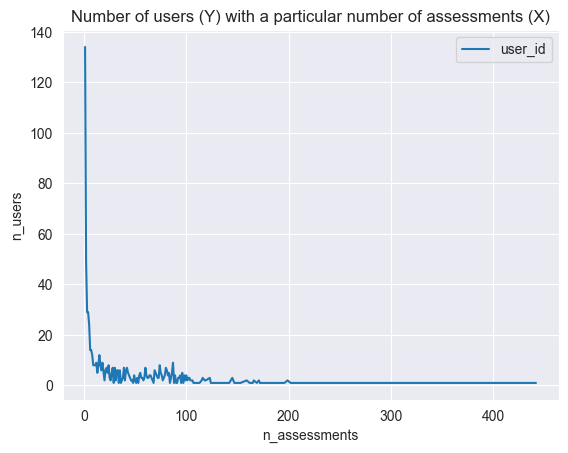

In [16]:
ax = sns.lineplot(
    pd.DataFrame(
        uniti_raw.user_id.value_counts().sort_values(ascending=True).value_counts()
    ).rename(
        {'index':'length', 'user_id':'n_users'}
    ))
ax.set_ylabel("n_users")
ax.set_xlabel("n_assessments")
ax.set_title("Number of users (Y) with a particular number of assessments (X)")
print("") #Just my hack to suppress the annoying seaborn output. Dunno how to turn it off, sorry.

##### There are some outlier users with 400+ assessments, just zooming in so you see the real deal

There are some outlier users with 400+ assessments, just zooming in so you see the real deal


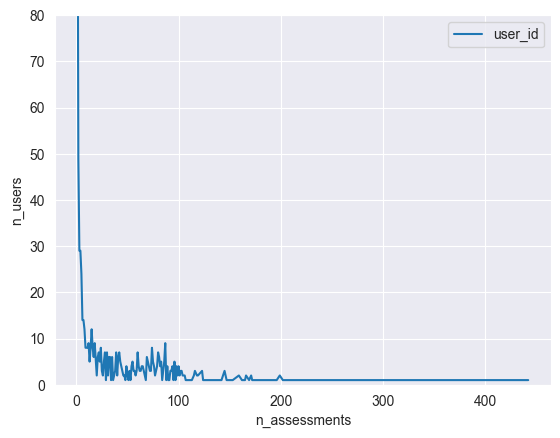

In [17]:
ax = sns.lineplot(pd.DataFrame(uniti_raw.user_id.value_counts().sort_values(ascending=True).value_counts()).rename({'index':'length', 'user_id':'n_users'}))
ax.set_xlabel("n_assessments")
ax.set_ylabel("n_users")
ax.set_ylim((0,80))
print("There are some outlier users with 400+ assessments, just zooming in so you see the real deal")

#### Date range of interactions:

In [18]:
uniti_date_info = pd.to_datetime(uniti_raw.created_at, format="%Y-%m-%d %H:%M:%S", errors='raise').describe(datetime_is_numeric=True)
print("First datestamp:", uniti_date_info['min'], 
      "\n25% of the data comes before:", uniti_date_info['25%'].date(),
     "\n50% of the data comes before:", uniti_date_info['50%'].date(),
     "\n75% of the data comes before:", uniti_date_info['75%'].date(),
     "\nLast datestamp:", uniti_date_info['max'])
print("Total span in days:", (uniti_date_info['max'] - uniti_date_info['min']).days, " days")

First datestamp: 2021-04-13 20:35:15 
25% of the data comes before: 2021-09-12 
50% of the data comes before: 2022-01-23 
75% of the data comes before: 2022-04-30 
Last datestamp: 2022-09-27 22:57:33
Total span in days: 532  days


#### How is the total span of the dataset related to the total span for each user?

##### Please take the n_assessments percentile value with a pinch of salt... The computation is a bit oversimplified, but still hopefully useful to get a sense of the data. If we want to be accurate, we should check the percentile values for n_assessments after filtering only for those users who have X days of data. That will give a clearer idea. 

If that disclaimer was not understandable, sorry. I think it is easier to explain over a call.

In [19]:
uniti_raw['date'] = [x.date() for x in pd.to_datetime(uniti_raw.created_at, format="%Y-%m-%d %H:%M:%S", errors='raise')]
user_date_spans = pd.DataFrame(uniti_raw.groupby(
                        'user_id', as_index=False).agg(
                            {'date': ['min','max','nunique']}).values, 
                    columns = ['user_id','datestamp_min','datestamp_max', 'n_assessments'])
user_date_spans['time_delta'] = user_date_spans['datestamp_max'] - user_date_spans['datestamp_min']
user_date_spans['n_assessments'] = user_date_spans['n_assessments'].astype(int)

user_date_spans_description = user_date_spans.describe()
print("The shortest user has a date-span of", user_date_spans_description['time_delta']['min'].days
      , "days of data with", user_date_spans_description['n_assessments']['min'], "assessments")

print("25% of the users have", user_date_spans_description['time_delta']['25%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['25%'],"assessments")
print("50% of the users have", user_date_spans_description['time_delta']['50%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['50%'],"assessments")
print("75% of the users have", user_date_spans_description['time_delta']['75%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['75%'],"assessments")



print("Max. is", user_date_spans_description['time_delta']['max'], "days of data with", user_date_spans_description['n_assessments']['max'], "assessments")


print("--------------------------------\nOn average, users have ", user_date_spans_description['time_delta']['mean'].days, 
      "+/-", user_date_spans_description['time_delta']['std'].days ,"days of data, with on average of",
      user_date_spans_description['n_assessments']['mean'], "+/-", user_date_spans_description['n_assessments']['std'], "assessments")



The shortest user has a date-span of 0 days of data with 1.0 assessments
25% of the users have 3 days of data, with 2.0 assessments
50% of the users have 44 days of data, with 16.0 assessments
75% of the users have 93 days of data, with 63.0 assessments
Max. is 504 days 00:00:00 days of data with 433.0 assessments
--------------------------------
On average, users have  68 +/- 83 days of data, with on average of 39.48885976408912 +/- 53.78798975246744 assessments


#### However, there are both anonymous and non-anonymous participants in the above dataset. If we remove anonymous participants, the statistics are as follows

In [20]:
uniti_non_anon = uniti_raw[uniti_raw.user_id < 42101].copy()
uniti_non_anon.loc[:,'assessment_quantile'] = uniti_non_anon.loc[:,'user_id'].map(pd.qcut(uniti_non_anon.user_id.value_counts(), 5).to_dict())

print("The distribution for number of users within a certain range of assessments submitted varies like in the table below:")
pd.DataFrame(uniti_non_anon.groupby('assessment_quantile')['user_id'].nunique()).reset_index().rename({'user_id':'n_users'}, axis=1)

The distribution for number of users within a certain range of assessments submitted varies like in the table below:


,assessment_quantile,n_users
0,"(0.999, 8.0]",110
1,"(8.0, 28.0]",111
2,"(28.0, 60.8]",102
3,"(60.8, 87.4]",108
4,"(87.4, 442.0]",108


In [21]:
#Sanity check
print(110+111+102+108+108, "users in table above, and", uniti_non_anon.user_id.nunique(), " non-anonymous users in the dataset")

539 users in table above, and 539  non-anonymous users in the dataset


The number of users with just one assessments drop very sharply if we filter for non anonymous users


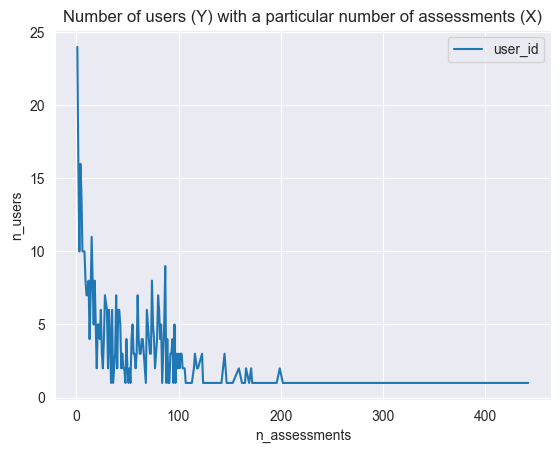

In [22]:
ax = sns.lineplot(
    pd.DataFrame(
        uniti_non_anon.user_id.value_counts().sort_values(ascending=True).value_counts()
    ).rename(
        {'index':'length', 'user_id':'n_users'}
    ))
ax.set_ylabel("n_users")
ax.set_xlabel("n_assessments")
ax.set_title("Number of users (Y) with a particular number of assessments (X)")
print("The number of users with just one assessments drop very sharply if we filter for non anonymous users") #Just my hack to suppress the annoying seaborn output. Dunno how to turn it off, sorry.

In [23]:
uniti_date_info = pd.to_datetime(uniti_non_anon.created_at, format="%Y-%m-%d %H:%M:%S", errors='raise').describe(datetime_is_numeric=True)
print("First datestamp:", uniti_date_info['min'], 
      "\n25% of the data comes before:", uniti_date_info['25%'].date(),
     "\n50% of the data comes before:", uniti_date_info['50%'].date(),
     "\n75% of the data comes before:", uniti_date_info['75%'].date(),
     "\nLast datestamp:", uniti_date_info['max'])
print("Total span in days:", (uniti_date_info['max'] - uniti_date_info['min']).days, " days")

print("The date range doesnt seem to change much, whether we filter out anons or not.")

First datestamp: 2021-04-16 16:16:03 
25% of the data comes before: 2021-09-10 
50% of the data comes before: 2022-01-21 
75% of the data comes before: 2022-04-29 
Last datestamp: 2022-09-27 22:57:33
Total span in days: 529  days
The date range doesnt seem to change much, whether we filter out anons or not.


In [24]:
uniti_non_anon['date'] = [x.date() for x in pd.to_datetime(uniti_non_anon.created_at, format="%Y-%m-%d %H:%M:%S", errors='raise')]
user_date_spans = pd.DataFrame(uniti_non_anon.groupby(
                        'user_id', as_index=False).agg(
                            {'date': ['min','max','nunique']}).values, 
                    columns = ['user_id','datestamp_min','datestamp_max', 'n_assessments'])
user_date_spans['time_delta'] = user_date_spans['datestamp_max'] - user_date_spans['datestamp_min']
user_date_spans['n_assessments'] = user_date_spans['n_assessments'].astype(int)

user_date_spans_description = user_date_spans.describe()
print("The shortest user has a date-span of", user_date_spans_description['time_delta']['min'].days
      , "days of data with", user_date_spans_description['n_assessments']['min'], "assessments")

print("25% of the users have", user_date_spans_description['time_delta']['25%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['25%'],"assessments")
print("50% of the users have", user_date_spans_description['time_delta']['50%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['50%'],"assessments")
print("75% of the users have", user_date_spans_description['time_delta']['75%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['75%'],"assessments")



print("Max. is", user_date_spans_description['time_delta']['max'], "days of data with", user_date_spans_description['n_assessments']['max'], "assessments")


print("--------------------------------\nOn average, users have ", user_date_spans_description['time_delta']['mean'].days, 
      "+/-", user_date_spans_description['time_delta']['std'].days ,"days of data, with on average of",
      user_date_spans_description['n_assessments']['mean'], "+/-", user_date_spans_description['n_assessments']['std'], "assessments")

print("The number of uber-short users drops sharply, because 25% of the users now have data spanning 23 days (with 11 assessments)")

The shortest user has a date-span of 0 days of data with 1.0 assessments
25% of the users have 23 days of data, with 11.0 assessments
50% of the users have 78 days of data, with 39.0 assessments
75% of the users have 109 days of data, with 78.0 assessments
Max. is 504 days 00:00:00 days of data with 433.0 assessments
--------------------------------
On average, users have  87 +/- 85 days of data, with on average of 52.84415584415584 +/- 57.24308872247093 assessments
The number of uber-short users drops sharply, because 25% of the users now have data spanning 23 days (with 11 assessments)


# Pointers for Target variable

###  A candidate for target variable (Regression) is "cumberness"


This is because it is a measure of the distress caused by the disease, and because there is no clear treatment that reliably reduces symptom severity, treating the distress caused by the disease (like in the case of chronic pain) is considered the thing to do, rather than treat the symptom severity.

###  If classification, target variable ("cumberness") discretisation can be attempted.:

(target in mean +/- user-defined noise threshold is "no change", 
target > mean + threashold is "worse", 
mean - threshold is "better")

### Candidate for features is all other questions excluding target:

[loudness, cumberness, jawbone, neck, tin_day, tin_cumber, tin_max, movement, stress, emotion]